# Imports

In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import torchvision

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [3]:
cd ../task2

/home/avashchilko/abbyy9sem/course_cvdl/task2


In [4]:
import abbyy_course_cvdl_t2
from abbyy_course_cvdl_t2.convert import PointsToObjects, ObjectsToPoints
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.loss import CenterNetLoss

In [5]:
cd ../task3

/home/avashchilko/abbyy9sem/course_cvdl/task3


In [6]:
device = torch.device('cuda:0')

# Data

In [7]:
base = Path("/home/avashchilko/coco2014")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'train'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


In [8]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:01.936915
creating index...
index created!


In [9]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [10]:
n_classes = 2
input_shape = (256, 256)

In [11]:
ds_train = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
),
    area_fraction_threshold=1/32/32
)

In [12]:
ds_val = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
    ),
    area_fraction_threshold=1/32/32,
    split='val'
)

In [13]:
x, y = ds_train[6]

In [14]:
y[:10]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   1.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   1.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

In [15]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True
)

In [16]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

# Learning

In [20]:
net = CenterNet(head_kwargs={'c_classes': n_classes}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=n_classes))#, l_size_lambda=3)

In [21]:
net = train(ds_train, net=net, criterion=crit, batch_size=64, epochs=100, device=torch.device(device), lr=1e-3)

epoch 0|0; total loss:26.74061393737793
last losses: [801.579833984375, 0.21203872561454773, 0.4264853000640869]
epoch 0|30; total loss:34.67018508911133
last losses: [2.1916933059692383, 0.26694339513778687, 0.2235928177833557]
epoch 0|60; total loss:2.6478769779205322
last losses: [1.8950003385543823, 0.23620226979255676, 0.2939344048500061]
epoch 0|90; total loss:2.293736696243286
last losses: [1.4556238651275635, 0.22167626023292542, 0.23780889809131622]
epoch 0|120; total loss:2.0806069374084473
last losses: [1.5786815881729126, 0.2811569273471832, 0.3221820294857025]
epoch 0|150; total loss:1.977295994758606
last losses: [1.3887450695037842, 0.23376555740833282, 0.2742541432380676]
epoch 0|180; total loss:1.8982722759246826
last losses: [1.4004422426223755, 0.2625439763069153, 0.3006731867790222]
epoch 0|210; total loss:1.8268333673477173
last losses: [1.5034656524658203, 0.2923913598060608, 0.23656360805034637]
epoch 0|240; total loss:1.7718545198440552
last losses: [1.382335662

epoch 7|0; total loss:0.03130461648106575
last losses: [0.5502090454101562, 0.21385198831558228, 0.1750774085521698]
epoch 7|30; total loss:0.8965051770210266
last losses: [0.4994124174118042, 0.20968736708164215, 0.18434523046016693]
epoch 7|60; total loss:0.8619464039802551
last losses: [0.49211347103118896, 0.19559268653392792, 0.16633185744285583]
epoch 7|90; total loss:0.9073379635810852
last losses: [0.6209636926651001, 0.22648809850215912, 0.2296951711177826]
epoch 7|120; total loss:0.8886457085609436
last losses: [0.5008077025413513, 0.2104608714580536, 0.17713242769241333]
epoch 7|150; total loss:0.9061259627342224
last losses: [0.6001009941101074, 0.2334589958190918, 0.2002253532409668]
epoch 7|180; total loss:0.969365119934082
last losses: [0.5553618669509888, 0.20608437061309814, 0.1721140295267105]
epoch 7|210; total loss:0.9469828605651855
last losses: [0.5764138698577881, 0.2290436178445816, 0.17860832810401917]
epoch 7|240; total loss:0.9522902369499207
last losses: [0.

epoch 13|270; total loss:0.615659236907959
last losses: [0.2714392840862274, 0.20067954063415527, 0.13250227272510529]
epoch 14|0; total loss:0.018398059532046318
last losses: [0.24822647869586945, 0.199579119682312, 0.10413612425327301]
epoch 14|30; total loss:0.5617997646331787
last losses: [0.21280458569526672, 0.15723606944084167, 0.0832233875989914]
epoch 14|60; total loss:0.5359417200088501
last losses: [0.2421075850725174, 0.18632331490516663, 0.12548914551734924]
epoch 14|90; total loss:0.5565984845161438
last losses: [0.24131202697753906, 0.2019265592098236, 0.12860609591007233]
epoch 14|120; total loss:0.5590644478797913
last losses: [0.28448766469955444, 0.18822848796844482, 0.15092583000659943]
epoch 14|150; total loss:0.5846083164215088
last losses: [0.28973305225372314, 0.19623136520385742, 0.11566607654094696]
epoch 14|180; total loss:0.5806345343589783
last losses: [0.30634474754333496, 0.20247937738895416, 0.12101395428180695]
epoch 14|210; total loss:0.571789860725402

epoch 20|240; total loss:0.41396576166152954
last losses: [0.14064446091651917, 0.1572885811328888, 0.09640032052993774]
epoch 20|270; total loss:0.43832823634147644
last losses: [0.2121957540512085, 0.19429273903369904, 0.11064866185188293]
epoch 21|0; total loss:0.014989265240728855
last losses: [0.14931854605674744, 0.18604736030101776, 0.1143120527267456]
epoch 21|30; total loss:0.4193565547466278
last losses: [0.1391746997833252, 0.1740117222070694, 0.10398435592651367]
epoch 21|60; total loss:0.40743815898895264
last losses: [0.11516395956277847, 0.15422961115837097, 0.09275518357753754]
epoch 21|90; total loss:0.41179269552230835
last losses: [0.1258266270160675, 0.16350817680358887, 0.09715471416711807]
epoch 21|120; total loss:0.40881869196891785
last losses: [0.15777724981307983, 0.15645085275173187, 0.08594019711017609]
epoch 21|150; total loss:0.4194849133491516
last losses: [0.19731196761131287, 0.19217798113822937, 0.11188431829214096]
epoch 21|180; total loss:0.405151486

epoch 27|210; total loss:0.3467157483100891
last losses: [0.1264432668685913, 0.18842801451683044, 0.09732027351856232]
epoch 27|240; total loss:0.35972732305526733
last losses: [0.06726976484060287, 0.14204023778438568, 0.06241840869188309]
epoch 27|270; total loss:0.3658865690231323
last losses: [0.17052799463272095, 0.18363671004772186, 0.10286316275596619]
epoch 28|0; total loss:0.012152241542935371
last losses: [0.0936797484755516, 0.17877131700515747, 0.09211614727973938]
epoch 28|30; total loss:0.3392099440097809
last losses: [0.09642887860536575, 0.13831575214862823, 0.07924012839794159]
epoch 28|60; total loss:0.33937203884124756
last losses: [0.1148742288351059, 0.16569781303405762, 0.10188625752925873]
epoch 28|90; total loss:0.33228999376296997
last losses: [0.10283447802066803, 0.1889609545469284, 0.09566069394350052]
epoch 28|120; total loss:0.3387517035007477
last losses: [0.0950954407453537, 0.13592159748077393, 0.08100662380456924]
epoch 28|150; total loss:0.3429642319

epoch 34|180; total loss:0.2899104654788971
last losses: [0.0896589383482933, 0.1713876873254776, 0.08282635360956192]
epoch 34|210; total loss:0.29309409856796265
last losses: [0.062058404088020325, 0.14703045785427094, 0.06390479952096939]
epoch 34|240; total loss:0.2972604036331177
last losses: [0.07928100228309631, 0.16219846904277802, 0.09645435959100723]
epoch 34|270; total loss:0.30613604187965393
last losses: [0.10211978852748871, 0.15717127919197083, 0.08902818709611893]
epoch 35|0; total loss:0.010866060853004456
last losses: [0.08740993589162827, 0.15190823376178741, 0.0866636112332344]
epoch 35|30; total loss:0.2839604914188385
last losses: [0.0836448073387146, 0.1325511336326599, 0.0635097548365593]
epoch 35|60; total loss:0.28001585602760315
last losses: [0.06668534874916077, 0.1180754005908966, 0.07721282541751862]
epoch 35|90; total loss:0.2874271273612976
last losses: [0.063748799264431, 0.12863917648792267, 0.07303496450185776]
epoch 35|120; total loss:0.2934463024139

epoch 41|120; total loss:0.2528694272041321
last losses: [0.051324471831321716, 0.10164283215999603, 0.04977135360240936]
epoch 41|150; total loss:0.23584607243537903
last losses: [0.07250028848648071, 0.1496579647064209, 0.07589178532361984]
epoch 41|180; total loss:0.24900740385055542
last losses: [0.04123653843998909, 0.1297937035560608, 0.08401955664157867]
epoch 41|210; total loss:0.24951066076755524
last losses: [0.05061003193259239, 0.1324354112148285, 0.06641128659248352]
epoch 41|240; total loss:0.25052687525749207
last losses: [0.048037704080343246, 0.12563550472259521, 0.06217271089553833]
epoch 41|270; total loss:0.25105082988739014
last losses: [0.0697837546467781, 0.1440182626247406, 0.07437916100025177]
epoch 42|0; total loss:0.007689392194151878
last losses: [0.05918426439166069, 0.11825019121170044, 0.05324729532003403]
epoch 42|30; total loss:0.24219296872615814
last losses: [0.09157179296016693, 0.12870419025421143, 0.0759853795170784]
epoch 42|60; total loss:0.24286

epoch 48|60; total loss:0.21892037987709045
last losses: [0.023868370801210403, 0.11210645735263824, 0.05507083609700203]
epoch 48|90; total loss:0.20168808102607727
last losses: [0.0336332842707634, 0.10279509425163269, 0.06055046245455742]
epoch 48|120; total loss:0.21037811040878296
last losses: [0.03140941634774208, 0.11247265338897705, 0.06194181367754936]
epoch 48|150; total loss:0.21010315418243408
last losses: [0.04052332043647766, 0.1257815957069397, 0.056450799107551575]
epoch 48|180; total loss:0.22459587454795837
last losses: [0.028572265058755875, 0.11910611391067505, 0.059636808931827545]
epoch 48|210; total loss:0.21864710748195648
last losses: [0.028165249153971672, 0.10981111228466034, 0.055897410959005356]
epoch 48|240; total loss:0.2189268171787262
last losses: [0.03535745292901993, 0.11711007356643677, 0.06397214531898499]
epoch 48|270; total loss:0.21681366860866547
last losses: [0.04285360500216484, 0.11290448158979416, 0.06213657557964325]
epoch 49|0; total loss:

epoch 55|0; total loss:0.005217540077865124
last losses: [0.019010810181498528, 0.08471228182315826, 0.052803099155426025]
epoch 55|30; total loss:0.18234381079673767
last losses: [0.014842456206679344, 0.09143497794866562, 0.042268604040145874]
epoch 55|60; total loss:0.18760405480861664
last losses: [0.017059441655874252, 0.08820784091949463, 0.05061245709657669]
epoch 55|90; total loss:0.19341838359832764
last losses: [0.04115855693817139, 0.1023653969168663, 0.06284289062023163]
epoch 55|120; total loss:0.18139596283435822
last losses: [0.03039730340242386, 0.08428629487752914, 0.053715575486421585]
epoch 55|150; total loss:0.18590708076953888
last losses: [0.016939399763941765, 0.09602512419223785, 0.051198601722717285]
epoch 55|180; total loss:0.1787554919719696
last losses: [0.043203920125961304, 0.1054081916809082, 0.053386587649583817]
epoch 55|210; total loss:0.1862887293100357
last losses: [0.04200313612818718, 0.08876209706068039, 0.04047041013836861]
epoch 55|240; total lo

epoch 61|240; total loss:0.16146628558635712
last losses: [0.026426151394844055, 0.0934145450592041, 0.04950642213225365]
epoch 61|270; total loss:0.15756404399871826
last losses: [0.013911494985222816, 0.07116538286209106, 0.05203459411859512]
epoch 62|0; total loss:0.004835906904190779
last losses: [0.011282505467534065, 0.08209723234176636, 0.051697470247745514]
epoch 62|30; total loss:0.1594616025686264
last losses: [0.021107107400894165, 0.09144475311040878, 0.05493008345365524]
epoch 62|60; total loss:0.16241100430488586
last losses: [0.025832030922174454, 0.07593758404254913, 0.04580869525671005]
epoch 62|90; total loss:0.16226798295974731
last losses: [0.009592769667506218, 0.07835661619901657, 0.0399397611618042]
epoch 62|120; total loss:0.15203192830085754
last losses: [0.01811024360358715, 0.09626951068639755, 0.06142953410744667]
epoch 62|150; total loss:0.1531088799238205
last losses: [0.02058127522468567, 0.0914294570684433, 0.061456985771656036]
epoch 62|180; total loss:

epoch 68|180; total loss:0.13849352300167084
last losses: [0.014739126898348331, 0.06955018639564514, 0.04813392460346222]
epoch 68|210; total loss:0.14109393954277039
last losses: [0.01719989813864231, 0.066587433218956, 0.04042389243841171]
epoch 68|240; total loss:0.14253683388233185
last losses: [0.008622203022241592, 0.07348114252090454, 0.051987819373607635]
epoch 68|270; total loss:0.14627490937709808
last losses: [0.019391285255551338, 0.07387948781251907, 0.05276922881603241]
epoch 69|0; total loss:0.004987472668290138
last losses: [0.0252979826182127, 0.07722803205251694, 0.04709815979003906]
epoch 69|30; total loss:0.13738855719566345
last losses: [0.01763337105512619, 0.09237304329872131, 0.0654633566737175]
epoch 69|60; total loss:0.1426997035741806
last losses: [0.007957622408866882, 0.07290324568748474, 0.05074293911457062]
epoch 69|90; total loss:0.13333779573440552
last losses: [0.008806460537016392, 0.06719106435775757, 0.04742458835244179]
epoch 69|120; total loss:0.

epoch 75|120; total loss:0.12580755352973938
last losses: [0.02109587751328945, 0.07511116564273834, 0.04255757853388786]
epoch 75|150; total loss:0.13408218324184418
last losses: [0.014148851856589317, 0.0753866583108902, 0.050046294927597046]
epoch 75|180; total loss:0.12930183112621307
last losses: [0.009552858769893646, 0.07485995441675186, 0.05289405584335327]
epoch 75|210; total loss:0.1343344748020172
last losses: [0.010004634037613869, 0.060213472694158554, 0.03838095813989639]
epoch 75|240; total loss:0.12424633651971817
last losses: [0.0069473739713430405, 0.06699283421039581, 0.045707445591688156]
epoch 75|270; total loss:0.12608318030834198
last losses: [0.02087383158504963, 0.07015866041183472, 0.051134608685970306]
epoch 76|0; total loss:0.004700707737356424
last losses: [0.008448518812656403, 0.07586610317230225, 0.05670659989118576]
epoch 76|30; total loss:0.1320628672838211
last losses: [0.008663946762681007, 0.06556733697652817, 0.048786722123622894]
epoch 76|60; tota

epoch 82|30; total loss:0.12275380641222
last losses: [0.015210961923003197, 0.07209191471338272, 0.048723191022872925]
epoch 82|60; total loss:0.11983897536993027
last losses: [0.02829761989414692, 0.06732434034347534, 0.05363509804010391]
epoch 82|90; total loss:0.11952801048755646
last losses: [0.00927833840250969, 0.05259070545434952, 0.0362849161028862]
epoch 82|120; total loss:0.12672536075115204
last losses: [0.014199369587004185, 0.07778709381818771, 0.05371927469968796]
epoch 82|150; total loss:0.11904583871364594
last losses: [0.010060429573059082, 0.06230463087558746, 0.0475102923810482]
epoch 82|180; total loss:0.12397994846105576
last losses: [0.014960715547204018, 0.06491495668888092, 0.043021008372306824]
epoch 82|210; total loss:0.12237267941236496
last losses: [0.015648379921913147, 0.06322971731424332, 0.03821318596601486]
epoch 82|240; total loss:0.12260203808546066
last losses: [0.011188264936208725, 0.06892795115709305, 0.05657056346535683]
epoch 82|270; total loss

epoch 88|240; total loss:0.111809141933918
last losses: [0.006942613050341606, 0.05783716216683388, 0.04622726887464523]
epoch 88|270; total loss:0.11152393370866776
last losses: [0.00800806563347578, 0.06306955218315125, 0.04598819836974144]
epoch 89|0; total loss:0.004223604686558247
last losses: [0.021224914118647575, 0.06163093447685242, 0.04385228455066681]
epoch 89|30; total loss:0.10726480931043625
last losses: [0.010720170103013515, 0.05916456878185272, 0.043268609791994095]
epoch 89|60; total loss:0.10427780449390411
last losses: [0.0044247726909816265, 0.04730129987001419, 0.031066572293639183]
epoch 89|90; total loss:0.10212605446577072
last losses: [0.005123100243508816, 0.06014779955148697, 0.035466913133859634]
epoch 89|120; total loss:0.09991952776908875
last losses: [0.002114842412993312, 0.05146222189068794, 0.03627222031354904]
epoch 89|150; total loss:0.1062428280711174
last losses: [0.006022500339895487, 0.047251634299755096, 0.03392769768834114]
epoch 89|180; total

epoch 95|150; total loss:0.0997614786028862
last losses: [0.006045676302164793, 0.04410703107714653, 0.03748621791601181]
epoch 95|180; total loss:0.09929251670837402
last losses: [0.002852936740964651, 0.04621388018131256, 0.034501105546951294]
epoch 95|210; total loss:0.09992790967226028
last losses: [0.0036944111343473196, 0.04904542118310928, 0.029797721654176712]
epoch 95|240; total loss:0.10294698178768158
last losses: [0.005673839244991541, 0.044586628675460815, 0.03386446833610535]
epoch 95|270; total loss:0.1054534763097763
last losses: [0.00691363587975502, 0.05096129700541496, 0.038854874670505524]
epoch 96|0; total loss:0.0029813062865287066
last losses: [0.004275101702660322, 0.04346473887562752, 0.04169934242963791]
epoch 96|30; total loss:0.09451702982187271
last losses: [0.003821456339210272, 0.050737760961055756, 0.03444083034992218]
epoch 96|60; total loss:0.09342481195926666
last losses: [0.00485032657161355, 0.048874255269765854, 0.030637269839644432]
epoch 96|90; t

In [22]:
torch.save(net, 'centernet.pth')

# Quality

## Postprocessing and visualization

In [28]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [17]:
net = torch.load('centernet.pth')

In [18]:
net.to(device)
net.eval()

CenterNet(
  (backbone): ResnetBackbone(
    (downscale): HeadlessPretrainedResnet18Encoder(
      (md): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3)

In [19]:
x, y = ds_train[6]

with torch.no_grad():
    yp_heat = net(x[None].to('cuda:0')).cpu()    
    yp = net(x[None].to('cuda:0'), return_objects=True).cpu()

class 0 heatmap


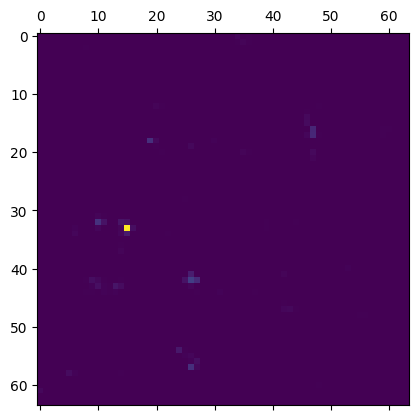

class 1 heatmap


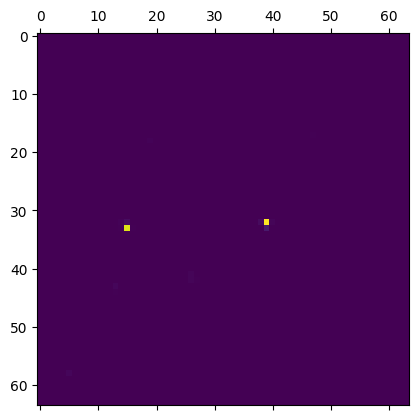

w_heatmap


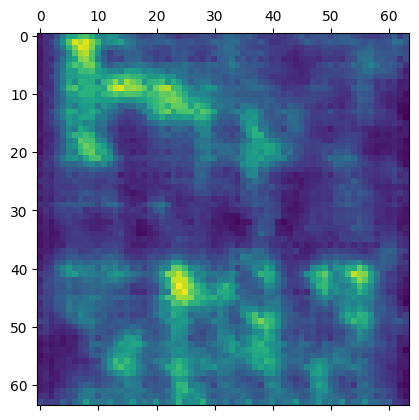

h heatmap


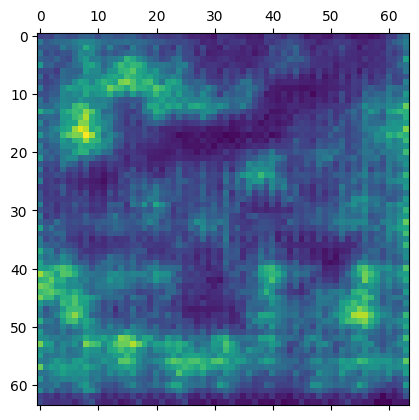

In [20]:
print('class 0 heatmap')
plt.matshow(yp_heat[0][0])
plt.show()

print('class 1 heatmap')
plt.matshow(yp_heat[0][1])
plt.show()

print('w_heatmap')
plt.matshow(yp_heat[0][-1])
plt.show()

print('h heatmap')
plt.matshow(yp_heat[0][-2])
plt.show()

In [21]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]

        hyd2 = torch.div(hy, 2, rounding_mode='trunc')
        wxd2 = torch.div(wx, 2, rounding_mode='trunc')

        img[
                yc - hyd2 - thick : yc - hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val
        img[
                yc + hyd2 - thick : yc + hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val

        img[
                yc - hyd2 : yc + hyd2, 
                (xc - wxd2 - thick): (xc - wxd2 + thick), 
        ] = val
        img[
                yc - hyd2 : yc + hyd2, 
                xc + wxd2 - thick: xc + wxd2 + thick, 
        ] = val
    return img


rnd = lambda x: torch.round(x).long()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


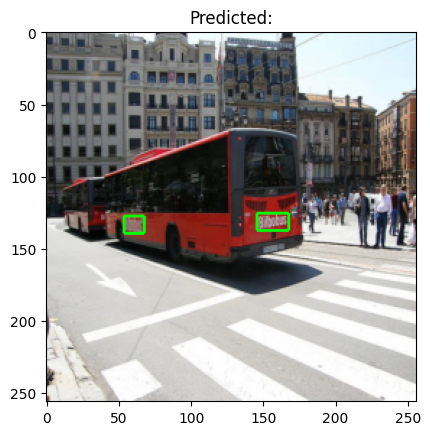

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


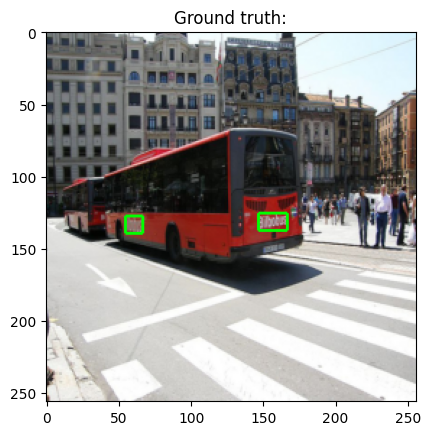

In [22]:
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
))
plt.title('Predicted:')
plt.show()
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
plt.title('Ground truth:')
plt.show()

In [23]:
print(yp[0][:2], y[:2])

tensor([[131.5881, 157.0396,  11.7893,  23.1500,   1.0000,   0.9760],
        [133.7882,  61.1264,  12.5048,  13.9831,   1.0000,   0.9283]]) tensor([[133.8933,  60.5600,  12.5333,  13.4400,   1.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   1.0000,   1.0000]])


## Saving to json

In [74]:
#net = torch.load('centernet.pth')

In [20]:
def postprocess(data, target_shape, input_shape):
    unf = {}
    res = data[data[:, -1] != 0]
    boxes = res[:, :4].copy()
    b = boxes.copy()
    result_boxes = np.zeros_like(boxes)
    result_boxes[:, 0] = (boxes[:, 1] - b[:, 3] / 2) * (target_shape[1] / input_shape[1])
    result_boxes[:, 1] = (boxes[:, 0] - b[:, 2] / 2) * (target_shape[0] / input_shape[0])
    result_boxes[:, 2] = boxes[:, 3] * (target_shape[1] / input_shape[1])
    result_boxes[:, 3] = boxes[:, 2] * (target_shape[0] / input_shape[0])
    unf['boxes'] = result_boxes
    unf['scores'] = res[:, -1]
    return unf


def extract_results():
    prepared_preds = []
    img_ids = []

    net.eval()

    for num, img_id in enumerate(tqdm(ds_val.ids)):
        img_id = int(img_id)
        img_meta = ct.loadImgs(ids=[img_id])[0]

        with torch.no_grad():
            x = ds_val[num][0]
            
            pred = net(
                x[None, ...].to(device),
                return_objects=True
            )[0].detach().cpu().numpy()
            prepared_preds.append(
                postprocess(pred, target_shape=(img_meta['height'], img_meta['width']), input_shape=input_shape)
            )
            img_ids.append(img_id)

    scores = np.concatenate([u['scores'] for u in prepared_preds], axis=0)
    boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)
    
    image_ids = []
    
    for num, i in enumerate(img_ids):
        image_ids += [i] * len(prepared_preds[num]['boxes'])
    image_ids = np.array(image_ids)

    dump_detections_to_cocotext_json(
        image_ids = image_ids.tolist(),
        xlefts=boxes[:, 0].tolist(),
        ytops=boxes[:, 1].tolist(),
        widths=boxes[:, 2].tolist(),
        heights=boxes[:, 3].tolist(),
        scores=scores.tolist(),
        path=f'predictions.json'
    )
    
    ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path=f'predictions.json'
    )
    return (ap, prec, rec, len(scores))

# Best AP

100%|████████████████████████████████████████████████████████████████████| 4446/4446 [01:00<00:00, 73.60it/s]


Loading and preparing results...     
DONE (t=0.15s)
Итоговый скор AP на val: 0.11244638984027419


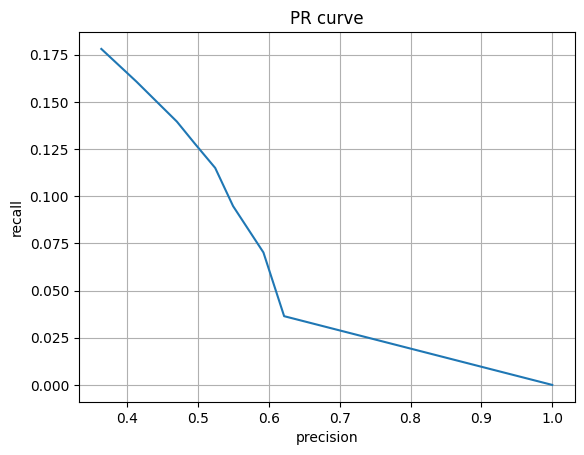

In [21]:
ap, prec, rec, n_obj = extract_results()

print(f"Итоговый скор AP на val: {ap}")

plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()

In [54]:
prec

[0.36369654437128335,
 0.36369654437128335,
 0.4133733532744083,
 0.44248803819282523,
 0.47029270413492946,
 0.4956041194434554,
 0.5243866389227353,
 0.5496240599437504,
 0.5924507655402348,
 0.6216814152415029]

In [55]:
rec

[0.1780413506916818,
 0.1780413506916818,
 0.1606714628193226,
 0.14984768940632265,
 0.13954242010891552,
 0.12787607750807725,
 0.11497828763270605,
 0.09475662712458638,
 0.07019249464837692,
 0.03642491412039504]